## Load libraries

In [1]:
import dask
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
import ocetrac
import warnings
warnings.filterwarnings('ignore')
from datetime import date
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# Load the precomputed climatology that I saved as an .nc file (climatology_dates)
mt_path = "/pub/mariant3/WarmWaterMasses/"
climatology_dates = xr.open_dataarray(f"{mt_path}/data/climatology/climatology-manso-0186-01-01-0189-12-31.nc")

## Calculate climatology for the region (skip)
If `climatology_dates` is loaded you can skip this climatology calculation until the "Running `ocetrac`" part below

In [4]:
# Loads the whole `tos` dataset. Takes ~5-10min
# dir_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/"
# ds = xr.open_mfdataset(f"{dir_path}/data/ocean_daily_cmip*.nc", chunks={'time':100})

In [56]:
region_tos = ds['tos'].sel(xh=slice(-130, -70), yh=slice(8, 38))

In [ ]:
mt_path = "/pub/mariant3/WarmWaterMasses/data/"
climatology_dates = xr.open_dataarray(f"{mt_path}/climatology/climatology-manso-0186-01-01-0189-12-31.nc")

In [71]:
doy = region_tos['time'].dt.dayofyear
region_climatology = region_tos.chunk(dict(time=-1)).groupby(doy).mean(dim='time')
region_climatology

<xarray.DataArray 'tos' (dayofyear: 365, yh: 132, xh: 236)>
dask.array<stack, shape=(365, 132, 236), dtype=float32, chunksize=(1, 132, 236), chunktype=numpy.ndarray>
Coordinates:
  * xh         (xh) float64 -129.8 -129.6 -129.3 -129.1 ... -70.67 -70.41 -70.16
  * yh         (yh) float64 8.222 8.469 8.716 8.963 ... 37.3 37.5 37.69 37.89
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [4]:
climatology_dates = xr.DataArray(
    region_climatology.sel(dayofyear=region_tos["time"].sel(time=slice("0186","0189")).dt.dayofyear), #.sel for the dates
    dims=["time", "yh", "xh"],
    coords={"time": region_tos["time"].sel(time=slice("0186","0189")), "xh": region_tos["xh"], "yh": region_tos["yh"]}
)
#Uncomment below to load
#climatology_dates = climatology_dates.load()

## Running `ocetrac`

In [3]:
#Define and start and end dates to run through ocetrac
start = climatology_dates.get_index("time").get_loc("0186-03-15").start #"0186-04-20" should work
end = climatology_dates.get_index("time").get_loc("0186-11-02").start #"0186-11-02"

In [17]:
#ocetrac procedure up to Tracker
hot_water = climatology_dates.isel(time=slice(start,end)) > 29
mask_ocean = 1 * np.ones(climatology_dates.shape[1:]) * np.isfinite(climatology_dates.isel(time=0))
mask_land = 0 * np.ones(climatology_dates.shape[1:]) * np.isnan(climatology_dates.isel(time=0))
mask = mask_ocean + mask_land
size_thresh = 0.75
radius= 4
Tracker = ocetrac.Tracker(hot_water, mask, radius=radius, min_size_quartile=size_thresh, timedim='time', xdim='xh', ydim='yh', positive=True)

In [18]:
#Run ocetrac
blobs = Tracker.track()

minimum area: 442.0
inital objects identified 	 533
final objects tracked 	 13


In [19]:
ids = np.unique(blobs)#.sel(xh = slice(-138, 0), yh = slice(8, 49))
ids = np.array([id for id in ids if ~np.isnan(id)])
ids

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.])

In [ ]:
#chekcing event times
#blobs.where(blobs == 8,drop=True).time

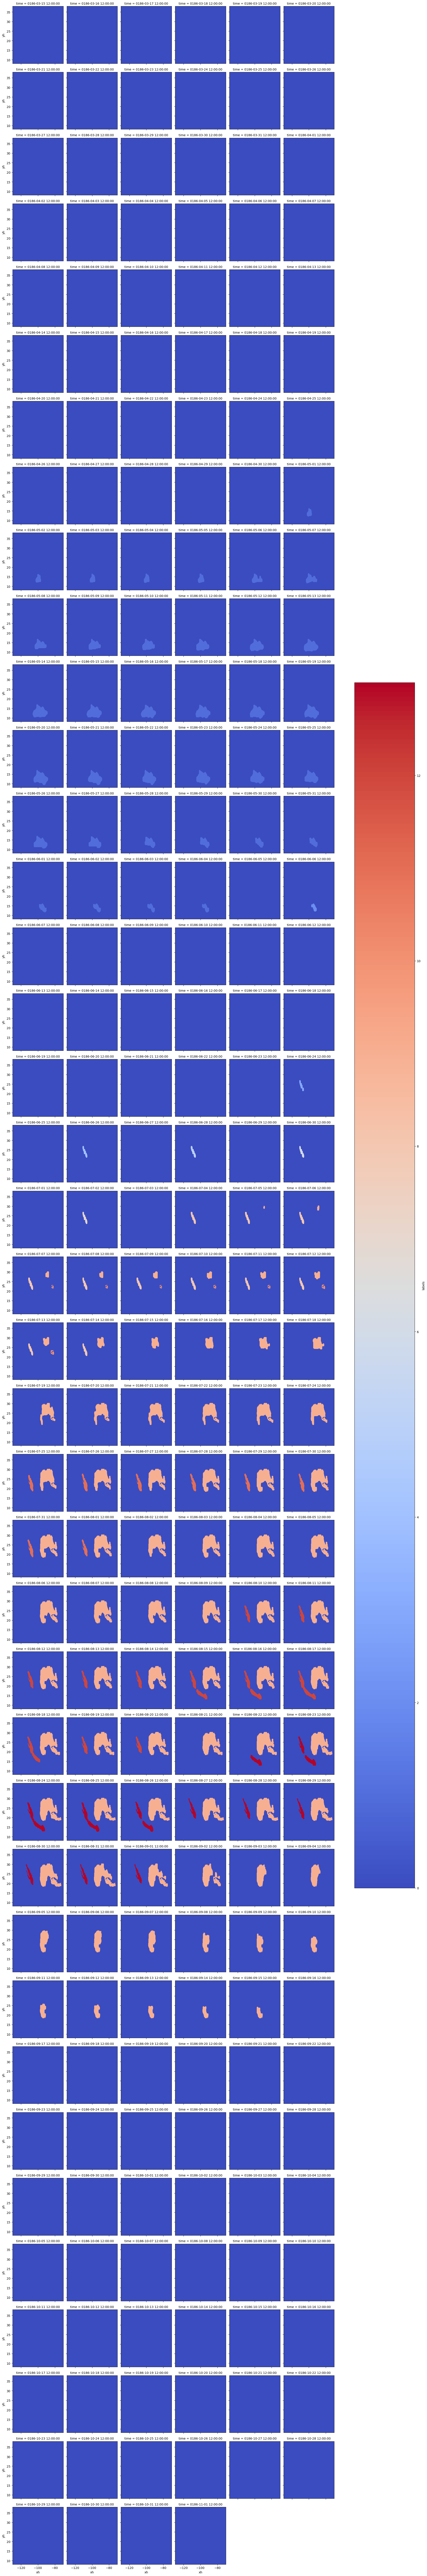

In [20]:
#plot events to check
blobs.where(~np.isnan(blobs), 0).sel(time=slice(blobs.time[0].values,blobs.time[-1].values)).plot(col="time",col_wrap=6, cmap='coolwarm')
plt.savefig(f"{mt_path}figures/check-ocetrac-v4-hfdfix-{size_thresh}-thresh-{radius}-radius.png")
#plt.show()

### Looking into the very small event in july

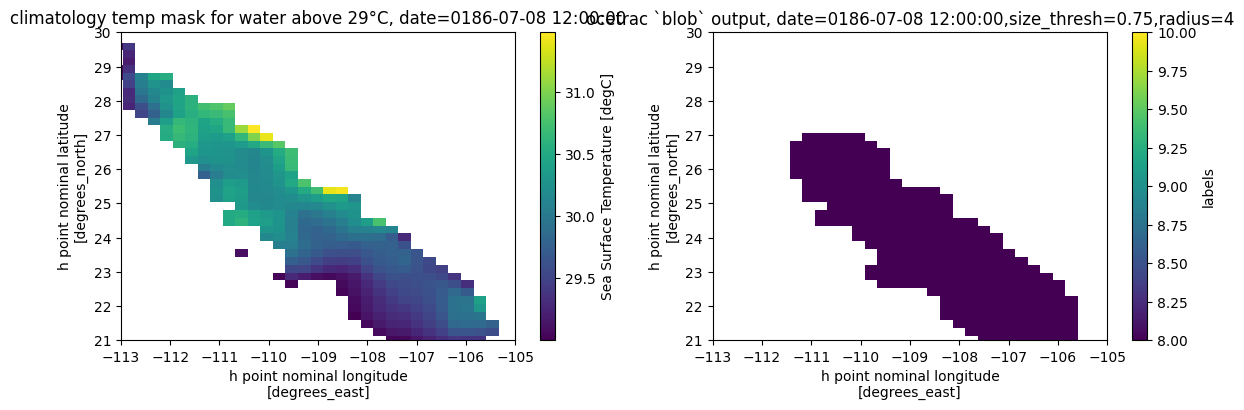

In [22]:
dates="0186-07-08"
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
climatology_dates.sel(time=f"{dates}").where(climatology_dates>29).plot(label="blob output")
plt.ylim(21,30)
plt.xlim(-113,-105)
plt.title(label=f"climatology temp mask for water above 29°C, date={climatology_dates.time.sel(time=dates).values[0]}")

plt.subplot(1, 2, 2)

blobs.sel(time=f"{dates}").plot()

plt.ylim(21,30)
plt.xlim(-113,-105)
plt.title(label=f"ocetrac `blob` output, date={blobs.time.sel(time=dates).values[0]},size_thresh={size_thresh},radius={radius}")
plt.savefig(f"{mt_path}figures/check-ocetrac-v4-hfdfix-{size_thresh}-thresh-{radius}-radius-zoomin.png")
plt.show()

In [ ]:
#Uncomment to save as .nc file
#climatology_dates.to_netcdf("/pub/mariant3/WarmWaterMasses/data/climatology/climatology-manso-tos-0186-01-01-0189-12-31.nc")

#### 95th percentile

In [22]:
per95 = region_tos.chunk(dict(time=-1)).groupby(doy).quantile(0.95, dim='time')
per95

<xarray.DataArray 'tos' (dayofyear: 365, yh: 132, xh: 236)>
dask.array<concatenate, shape=(365, 132, 236), dtype=float64, chunksize=(1, 132, 236), chunktype=numpy.ndarray>
Coordinates:
  * xh         (xh) float64 -129.8 -129.6 -129.3 -129.1 ... -70.67 -70.41 -70.16
  * yh         (yh) float64 8.222 8.469 8.716 8.963 ... 37.3 37.5 37.69 37.89
    quantile   float64 0.95
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

In [24]:
per95_dates = xr.DataArray(
    per95.sel(dayofyear=region_tos['time'].sel(time=slice("0186","0189")).dt.dayofyear),
    dims=["time", "yh", "xh"],
    coords={"time": region_tos['time'].sel(time=slice("0186","0189")), "xh": region_tos["xh"], "yh": region_tos["yh"]}
)
per95_dates

<xarray.DataArray 'tos' (time: 1460, yh: 132, xh: 236)>
dask.array<getitem, shape=(1460, 132, 236), dtype=float64, chunksize=(1, 132, 236), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0186-01-01 12:00:00 ... 0189-12-31 12:00:00
  * xh       (xh) float64 -129.8 -129.6 -129.3 -129.1 ... -70.67 -70.41 -70.16
  * yh       (yh) float64 8.222 8.469 8.716 8.963 9.21 ... 37.3 37.5 37.69 37.89

In [26]:
#per95_dates.to_netcdf("/pub/mariant3/WarmWaterMasses/data/per95-manso-0186-01-01-0189-12-31.nc")